Loading dataset and extracting features...
Successfully loaded 3600 samples (1800 real, 1800 fake)
Preprocessing data...
Saved 1000 samples for LIME explainer at X_train_sample_7.pkl
Training model...
[LightGBM] [Info] Number of positive: 1440, number of negative: 1440
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


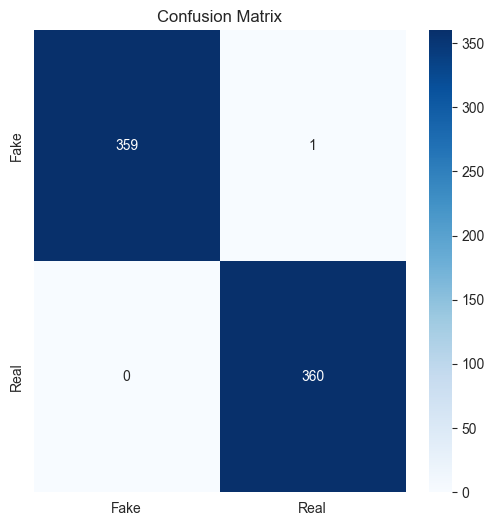

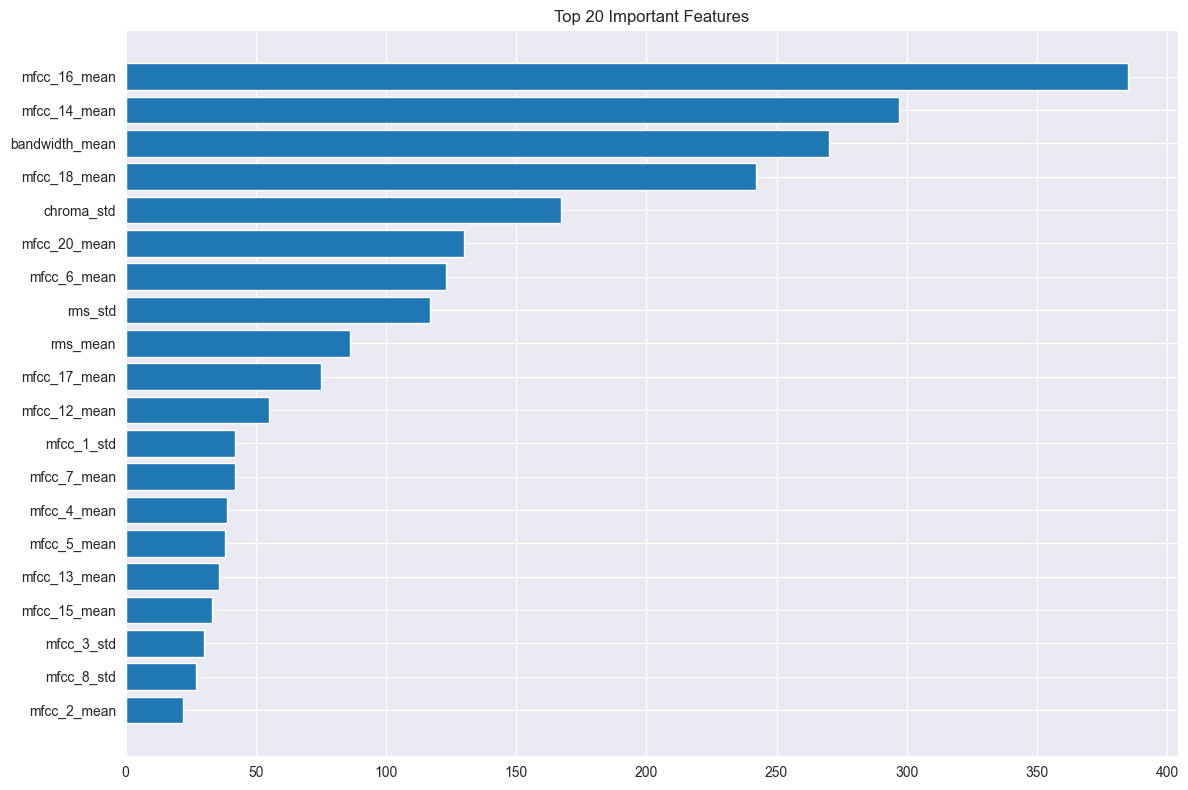


Generating SHAP summary plot...


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


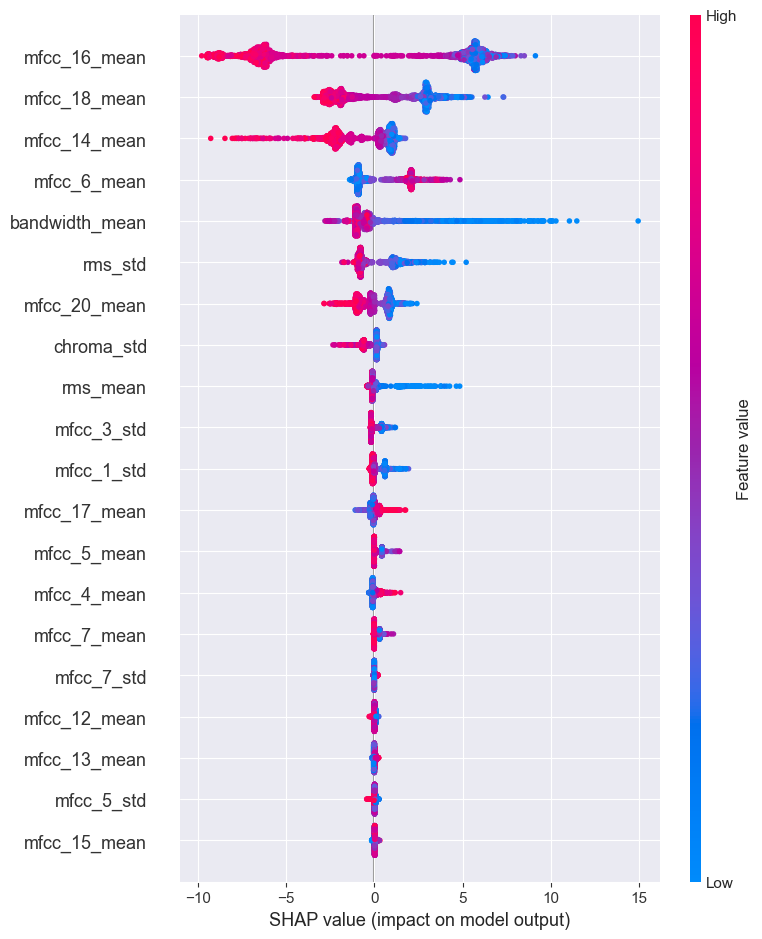

Model saved to audio_detection_model_7.pkl
Scaler saved to scaler_7.pkl

Testing with file: c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/fake/fake_1.wav

Fake: 1.0000, Real: 0.0000, Prediction: Fake

Top Contributing Features (LightGBM):
mfcc_16_mean: -6.6928
mfcc_18_mean: -2.1617
mfcc_14_mean: -1.9894
mfcc_20_mean: -0.9861
bandwidth_mean: -0.9546


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


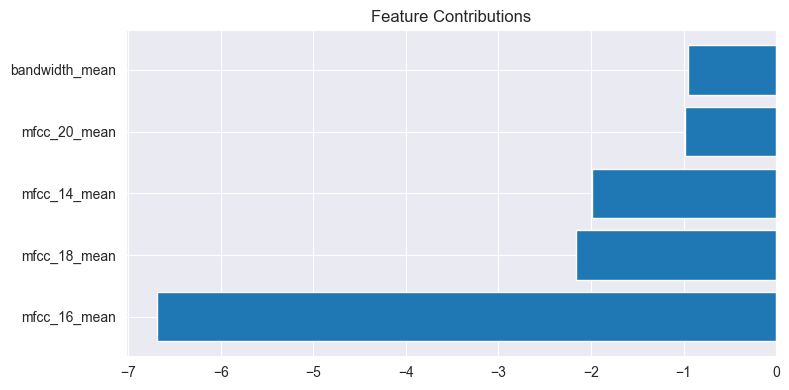


Generating SHAP explanation...
SHAP explanation error: invalid index to scalar variable.

Generating LIME explanation...
Loaded LIME sample data with shape: (1000, 52)


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Top contributing features (LIME):
mfcc_16_mean: 0.1529
mfcc_18_mean: 0.1275
mfcc_14_mean: 0.1181
bandwidth_mean: 0.0665
mfcc_6_mean: -0.0653
LIME explanation error: 1


In [3]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from lime import lime_tabular

# --------------------- SETTINGS ---------------------
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
SR = 22050  # Sample rate
N_MFCC = 20  # Number of MFCC coefficients
TEST_SIZE = 0.2
RANDOM_STATE = 42
MODEL_SAVE_PATH = "audio_detection_model_7.pkl"
SCALER_SAVE_PATH = "scaler_7.pkl"
SAMPLE_SAVE_PATH = "X_train_sample_7.pkl"  # Sample data for LIME explainer

# --------------------- FEATURE EXTRACTION ---------------------
def extract_features(file_path):
    try:
        audio, _ = librosa.load(file_path, sr=SR)
        features = []

        # MFCCs
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=N_MFCC)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # Chroma Features
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR)
        features.append(np.mean(chroma))
        features.append(np.std(chroma))

        # Spectral Features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        features.append(np.mean(spectral_centroid))
        features.append(np.std(spectral_centroid))

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        features.append(np.mean(spectral_bandwidth))
        features.append(np.std(spectral_bandwidth))

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(audio)
        features.append(np.mean(zcr))
        features.append(np.std(zcr))

        # RMS Energy
        rms = librosa.feature.rms(y=audio)
        features.append(np.mean(rms))
        features.append(np.std(rms))

        # Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)
        features.append(np.mean(rolloff))
        features.append(np.std(rolloff))

        return np.array(features)
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# --------------------- DATA LOADING ---------------------
def load_dataset(data_dir):
    X = []
    y = []

    real_dir = os.path.join(data_dir, "real")
    if not os.path.exists(real_dir):
        raise FileNotFoundError(f"Real audio directory not found at {real_dir}")

    fake_dir = os.path.join(data_dir, "fake")
    if not os.path.exists(fake_dir):
        raise FileNotFoundError(f"Fake audio directory not found at {fake_dir}")

    # Process real audio files
    real_files = [f for f in os.listdir(real_dir) if f.endswith(".wav")]
    if not real_files:
        raise ValueError(f"No WAV files found in {real_dir}")

    for filename in real_files:
        filepath = os.path.join(real_dir, filename)
        features = extract_features(filepath)
        if features is not None:
            X.append(features)
            y.append(1)  # Real audio

    # Process fake audio files
    fake_files = [f for f in os.listdir(fake_dir) if f.endswith(".wav")]
    if not fake_files:
        raise ValueError(f"No WAV files found in {fake_dir}")

    for filename in fake_files:
        filepath = os.path.join(fake_dir, filename)
        features = extract_features(filepath)
        if features is not None:
            X.append(features)
            y.append(0)  # Fake audio

    if not X:
        raise ValueError("No valid audio files found in either real or fake directories")

    return np.array(X), np.array(y)

# --------------------- TRAINING ---------------------
def train_model():
    print("Loading dataset and extracting features...")
    try:
        X, y = load_dataset(DATA_DIR)
        print(f"Successfully loaded {len(X)} samples ({sum(y)} real, {len(y)-sum(y)} fake)")
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return None, None, None

    feature_names = (
        [f"mfcc_{i}_mean" for i in range(1, N_MFCC + 1)] +
        [f"mfcc_{i}_std" for i in range(1, N_MFCC + 1)] +
        ["chroma_mean", "chroma_std",
         "centroid_mean", "centroid_std",
         "bandwidth_mean", "bandwidth_std",
         "zcr_mean", "zcr_std",
         "rms_mean", "rms_std",
         "rolloff_mean", "rolloff_std"]
    )

    print("Preprocessing data...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y
    )

    # Handle sample size for LIME
    sample_size = min(1000, X_train.shape[0])
    if sample_size < 100:
        print(f"Warning: Small sample size ({sample_size}) for LIME explainer. Results may be less reliable.")

    try:
        sample_indices = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
        X_train_sample = X_train[sample_indices]
        joblib.dump(X_train_sample, SAMPLE_SAVE_PATH)
        print(f"Saved {sample_size} samples for LIME explainer at {SAMPLE_SAVE_PATH}")
    except Exception as e:
        print(f"Error creating LIME sample: {str(e)}")
        return None, None, None

    print("Training model...")
    try:
        model = LGBMClassifier(
            n_estimators=150,
            learning_rate=0.1,
            max_depth=7,
            num_leaves=31,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        model.fit(X_train, y_train)

        print(f"\nAccuracy: {accuracy_score(y_test, model.predict(X_test)):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, model.predict(X_test)))

        # Plot confusion matrix
        cm = confusion_matrix(y_test, model.predict(X_test))
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
        plt.title("Confusion Matrix")
        plt.show()

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        importance = model.feature_importances_
        sorted_idx = importance.argsort()
        plt.barh(np.array(feature_names)[sorted_idx[-20:]], importance[sorted_idx[-20:]])
        plt.title("Top 20 Important Features")
        plt.tight_layout()
        plt.show()

        # SHAP summary plot
        print("\nGenerating SHAP summary plot...")
        try:
            explainer_shap = shap.TreeExplainer(model)
            shap_values = explainer_shap.shap_values(X_train)
            shap_values_matrix = shap_values[1] if isinstance(shap_values, list) else shap_values
            shap.summary_plot(shap_values_matrix, X_train, feature_names=feature_names)
        except Exception as e:
            print(f"SHAP Error: {e}")

        # Save model and scaler
        joblib.dump(model, MODEL_SAVE_PATH)
        joblib.dump(scaler, SCALER_SAVE_PATH)
        print(f"Model saved to {MODEL_SAVE_PATH}")
        print(f"Scaler saved to {SCALER_SAVE_PATH}")

        return model, scaler, feature_names

    except Exception as e:
        print(f"Error during model training: {str(e)}")
        return None, None, None

# --------------------- PREDICTION ---------------------
def predict_audio(file_path, model, scaler, feature_names):
    if model is None or scaler is None:
        print("Model or scaler not loaded properly")
        return None

    features = extract_features(file_path)
    if features is None:
        print("Error: Could not extract features from audio file")
        return None

    features_scaled = scaler.transform([features])
    proba = model.predict_proba(features_scaled)[0]
    prediction = model.predict(features_scaled)[0]

    print(f"\nFake: {proba[0]:.4f}, Real: {proba[1]:.4f}, Prediction: {'Real' if prediction == 1 else 'Fake'}")

    try:
        explain_prediction(features_scaled[0], model, feature_names)
    except Exception as e:
        print(f"Error explaining prediction: {str(e)}")

    try:
        print("\nGenerating SHAP explanation...")
        explainer_shap = shap.TreeExplainer(model)
        shap_values_single = explainer_shap.shap_values(features_scaled)
        shap_values_positive = shap_values_single[1] if isinstance(shap_values_single, list) else shap_values_single
        shap.force_plot(explainer_shap.expected_value[1], shap_values_positive[0], features_scaled[0],
                       feature_names=feature_names, matplotlib=True)
    except Exception as e:
        print(f"SHAP explanation error: {e}")

    try:
        print("\nGenerating LIME explanation...")
        if not os.path.exists(SAMPLE_SAVE_PATH):
            print("LIME sample data not found")
        else:
            X_train_sample = joblib.load(SAMPLE_SAVE_PATH)
            print(f"Loaded LIME sample data with shape: {X_train_sample.shape}")

            explainer_lime = lime_tabular.LimeTabularExplainer(
                training_data=X_train_sample,
                feature_names=feature_names,
                class_names=["Fake", "Real"],
                mode='classification',
                discretize_continuous=False
            )
            exp = explainer_lime.explain_instance(features_scaled[0], model.predict_proba, num_features=5, top_labels=1)
            label = exp.top_labels[0]
            print("\nTop contributing features (LIME):")
            for feature, weight in exp.local_exp[label]:
                print(f"{feature_names[feature]}: {weight:.4f}")
            exp.as_pyplot_figure()
            plt.title("LIME Explanation")
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"LIME explanation error: {e}")

    return prediction

def explain_prediction(features, model, feature_names, top_n=5):
    try:
        contributions = model.predict_proba([features], pred_contrib=True)[0][:-1]
        sorted_idx = np.argsort(np.abs(contributions))[::-1]
        print("\nTop Contributing Features (LightGBM):")
        for i in range(top_n):
            idx = sorted_idx[i]
            print(f"{feature_names[idx]}: {contributions[idx]:.4f}")
        plt.figure(figsize=(8, 4))
        plt.barh(np.array(feature_names)[sorted_idx[:top_n]], contributions[sorted_idx[:top_n]])
        plt.title("Feature Contributions")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Prediction explanation error: {e}")

# --------------------- MAIN ---------------------
if __name__ == "__main__":
    model, scaler, feature_names = train_model()

    if model is not None and scaler is not None:
        test_file = os.path.join(DATA_DIR, "fake/fake_1.wav")  # Changed path to lowercase 'fake'
        if not os.path.exists(test_file):
            test_file = os.path.join(DATA_DIR, "Fake/fake_1.wav")  # Try with uppercase 'Fake'

        if os.path.exists(test_file):
            print(f"\nTesting with file: {test_file}")
            predict_audio(test_file, model, scaler, feature_names)
        else:
            print(f"Test file not found at either location: {test_file}")
    else:
        print("Model training failed, cannot proceed with prediction")

In [4]:
import streamlit as st
import librosa
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import tempfile
import os
from tensorflow.keras.models import load_model

# Configuration
MODEL_PATH = "nn_audio_model.h5"
SCALER_PATH = "nn_scaler.pkl"
SAMPLE_RATE = 22050
N_MFCC = 20

FEATURE_NAMES = [
    *[f"mfcc_{i}_mean" for i in range(N_MFCC)],
    *[f"mfcc_{i}_std" for i in range(N_MFCC)],
    'chroma_mean', 'chroma_std',
    'spectral_centroid_mean', 'spectral_centroid_std',
    'spectral_bandwidth_mean', 'spectral_bandwidth_std',
    'spectral_rolloff_mean', 'spectral_rolloff_std',
    'zcr_mean', 'zcr_std',
    'rms_mean', 'rms_std'
]

def extract_features(file_path):
    """Feature extraction matching training pipeline"""
    try:
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE)
        features = []

        # MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # Chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=SAMPLE_RATE)
        features.append(np.mean(chroma))
        features.append(np.std(chroma))

        # Spectral features
        features.append(np.mean(librosa.feature.spectral_centroid(y=audio, sr=SAMPLE_RATE)))
        features.append(np.std(librosa.feature.spectral_centroid(y=audio, sr=SAMPLE_RATE)))
        features.append(np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=SAMPLE_RATE)))
        features.append(np.std(librosa.feature.spectral_bandwidth(y=audio, sr=SAMPLE_RATE)))
        features.append(np.mean(librosa.feature.spectral_rolloff(y=audio, sr=SAMPLE_RATE)))
        features.append(np.std(librosa.feature.spectral_rolloff(y=audio, sr=SAMPLE_RATE)))

        # Zero crossing + RMS
        features.append(np.mean(librosa.feature.zero_crossing_rate(audio)))
        features.append(np.std(librosa.feature.zero_crossing_rate(audio)))
        features.append(np.mean(librosa.feature.rms(y=audio)))
        features.append(np.std(librosa.feature.rms(y=audio)))

        return np.array(features)
    except Exception as e:
        st.error(f"Feature extraction failed: {str(e)}")
        return None

def main():
    st.title("Audio Authenticity Detector")

    # Load model and scaler
    try:
        model = load_model(MODEL_PATH)
        scaler = joblib.load(SCALER_PATH)
        st.success("Model components loaded successfully")
    except Exception as e:
        st.error(f"Loading failed: {str(e)}")
        return

    # File uploader
    uploaded_file = st.file_uploader("Upload WAV file", type=["wav"])

    if uploaded_file:
        # Save to temp file
        with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
            tmp_file.write(uploaded_file.read())
            tmp_path = tmp_file.name

        try:
            # Process audio
            features = extract_features(tmp_path)
            os.remove(tmp_path)  # Cleanup

            if features is None or len(features) != len(FEATURE_NAMES):
                st.error("Invalid audio features")
                return

            # Preprocess and predict
            features_scaled = scaler.transform([features])
            proba = model.predict(features_scaled, verbose=0)[0]
            prediction = np.argmax(proba)

            # Display results
            st.subheader("Analysis Results")
            col1, col2 = st.columns(2)
            col1.metric("Prediction", "Real" if prediction == 1 else "Fake")
            col2.metric("Confidence", f"{proba[prediction]*100:.1f}%")

            # SHAP Explanation
            st.subheader("Feature Contributions")

            # Generate SHAP values
            background = shap.sample(features_scaled, 50)  # Reduced sample size
            explainer = shap.DeepExplainer(model, background)
            shap_values = explainer.shap_values(features_scaled)

            # Real class explanation
            st.markdown("### Real Audio Contributions")
            plt.figure(figsize=(12, 4))
            shap.force_plot(
                explainer.expected_value[1],
                shap_values[1][0],
                features_scaled[0],
                feature_names=FEATURE_NAMES,
                matplotlib=True,
                show=False
            )
            st.pyplot(plt.gcf())
            plt.close()

            # Feature importance plot
            st.markdown("### Top Influential Features")
            plt.figure(figsize=(10, 6))
            shap.summary_plot(
                shap_values[1],
                features_scaled,
                feature_names=FEATURE_NAMES,
                plot_type="bar",
                show=False
            )
            st.pyplot(plt.gcf())
            plt.close()

        except Exception as e:
            st.error(f"Analysis failed: {str(e)}")

if __name__ == "__main__":
    main()

2025-04-23 23:02:09.949 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 23:02:10.777 
  command:

    streamlit run C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-04-23 23:02:10.777 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 23:02:10.785 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 23:02:10.785 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Loading dataset...
Preprocessing data...
Training neural network...


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9110 - loss: 0.1921 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 6.2424e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.5530e-04 - val_accuracy: 1.0000 - val_loss: 5.0472e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.0379e-04 - val_accuracy: 1.0000 - val_loss: 5.5403e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4072e-04 - val_accuracy: 1.0000 - val_loss: 3.6873e-04
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.6361e-04 - 

2025-04-23 23:04:41.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 23:04:41.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 23:04:41.589 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 23:04:41.595 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 23:04:41.596 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Model saved to nn_audio_model.h5
